# Lymph node data

I reasoned that it is good to start with a sample for which we can definetively exprect to see (1) cell trajectories, (2) cell-cell communications, (3) spatial redistribution of cellular subsets after interactions.

Therefore, I will use 2 data-sets:  
1. Visium 10x - human Lymph node 'V1_Human_Lymph_Node'  https://scanpy.readthedocs.io/en/stable/api/scanpy.datasets.visium_sge.html?highlight=sc.datasets.visium_sge
2. Healthy human reference LN samples from a publication investigating NSCLC LN metestases. https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE131907  
https://www.nature.com/articles/s41467-020-16164-1

Analysis steps:  
I. scRNA-seq data  
1. Load data
2. Quality Control and normalization
3. Low dimensional (UMAP) embedding and Clustering
4. Perform trajectory analysis (define traj_state_bins)
5. run ligrec with CellPhoneDB to predict CCI
6. map CCI onto trajectories

II. Visium data  
1. Load data
2. Identify clusters
3. Deconvolute clusters with cell types/traj_state_bins
4. Asses co-localization within clusters and at cluster-borders


## I. scRNA-seq data 

### 1. Load data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# scLN = sc.read_umi_tools("../02_data/01_raw_data/LN_scRNA_seq/GSE131907_Lung_Cancer_raw_UMI_matrix.txt.gz")
# did not work. for some reason there were only 50 cells or samples.

I loaded the GSE131907_Lung_Cancer_raw_UMI_matrix.rds file provided on GEO intor R. For this I had to generate a new R project and changed the r environment R_MAX_VSIZE to 100GB. The rds-file contained a data.frame with the barcode_sample-annotated cells. I selected the cells taken from healthy lymph nodes and exported the table as csv. Now, I can load the csv into python and transform it into a andata object!

In [2]:
scLN = sc.read_csv("../02_data/02_processed_data/GSE131907_nLN_raw_UMI_matrix.csv")

In [3]:
# vars are supposed to be the genes, obs the cells
scLN = scLN.transpose()

Annotate scRNA-seq data.

In [4]:
annotation = pd.read_csv("../02_data/02_processed_data/GSE131907_Lung_Cancer_cell_annotation.txt", sep="\t")
annotation.index = annotation["Index"]

In [8]:
scLN.obs.index.values

array(['AAACCTGAGAAACCGC_LN_05', 'AAACCTGAGACATAAC_LN_04',
       'AAACCTGAGCAGGTCA_LN_12', ..., 'TTTGTCATCTTCGAGA_LN_03',
       'TTTGTCATCTTCTGGC_LN_03', 'TTTGTCATCTTGAGGT_LN_01'], dtype=object)

In [9]:
annotation.index.values

array(['AAACCTGCAAGGTGTG_LUNG_N01', 'AACTCCCGTTCACCTC_LUNG_N01',
       'AACTCCCTCACGCGGT_LUNG_N01', ..., 'TTCTCCTCATCGACGC_NS_19',
       'TTGGAACTCGATGAGG_NS_19', 'TTTGCGCCAAGTCATC_NS_19'], dtype=object)

In [10]:
bool_ls = np.in1d(annotation["Index"], scLN.obs.index.values)

In [11]:
# is bool_ls non-zero at any point? --> YES!
stats.describe(bool_ls)

DescribeResult(nobs=208506, minmax=(False, True), mean=0.17959195418836868, variance=0.1473393908225814, skewness=1.6694561460893858, kurtosis=0.787083823715621)

In [12]:
annotation = annotation.loc[bool_ls,]

In [13]:
scLN.obs["sample"] = annotation["Sample"]
scLN.obs["Sample_Origin"] = annotation["Sample_Origin"]
scLN.obs["Cell_type.refined"] = annotation["Cell_type.refined"]
scLN.obs["Cell_subtype"] = annotation["Cell_subtype"]

In [14]:
scLN.var_names_make_unique()  

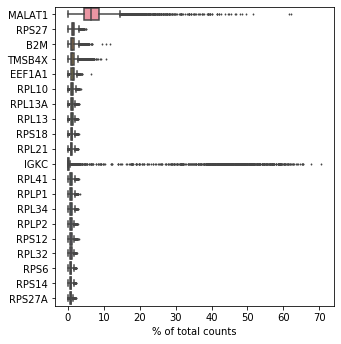

In [15]:
sc.pl.highest_expr_genes(scLN, n_top=20, )

### 2. Quality Control and Normalization

In [16]:
scLN.var["mt"] = scLN.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(scLN, qc_vars=["mt"], inplace=True)

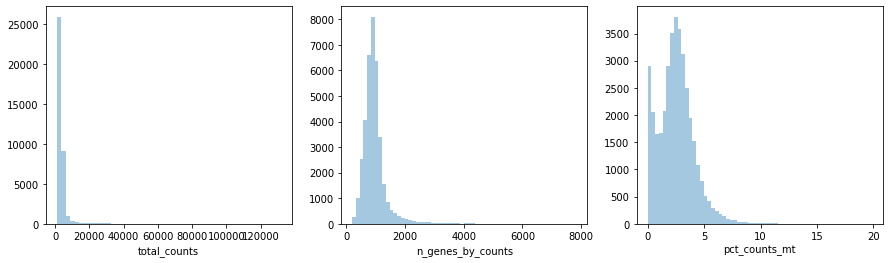

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.distplot(scLN.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(scLN.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])
sns.distplot(scLN.obs["pct_counts_mt"], kde=False, bins=60, ax=axs[2])

... storing 'sample' as categorical
... storing 'Sample_Origin' as categorical
... storing 'Cell_type.refined' as categorical
... storing 'Cell_subtype' as categorical


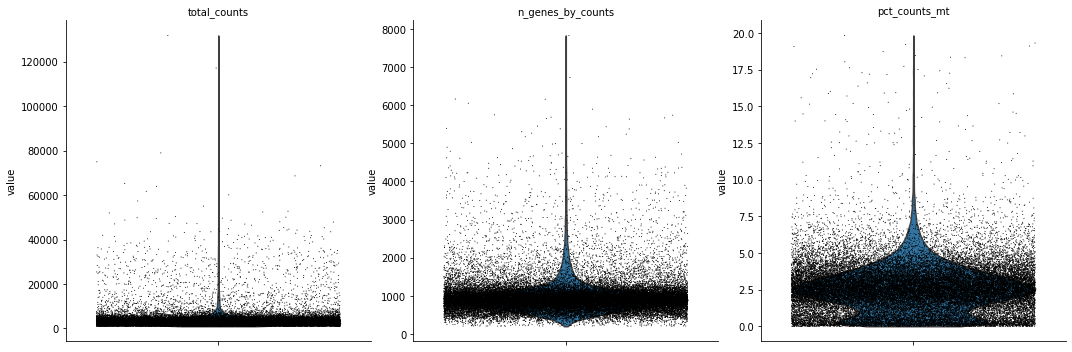

In [18]:
sc.pl.violin(scLN, ['total_counts','n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

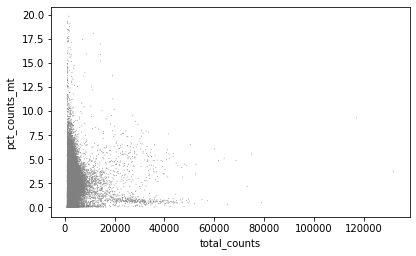

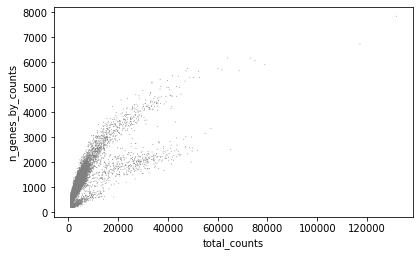

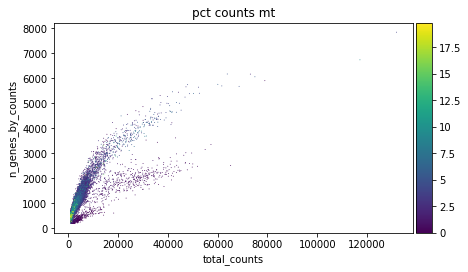

In [19]:
sc.pl.scatter(scLN, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scLN, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(scLN, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

In [20]:
# remove outliers
scLN = scLN[scLN.obs.total_counts < 18000, :]
scLN = scLN[scLN.obs.n_genes_by_counts < 2000, :]
scLN = scLN[scLN.obs.pct_counts_mt < 7, :]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


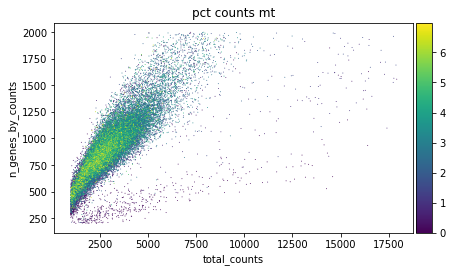

In [21]:
sc.pl.scatter(scLN, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

In [22]:
# Normalize counts to 10,000 reads per cell
sc.pp.normalize_total(scLN, target_sum=1e4)

/Users/albero/scanpy/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
# Logarithmize the data
sc.pp.log1p(scLN)

In [24]:
# Identify highly variable genes
sc.pp.highly_variable_genes(scLN)

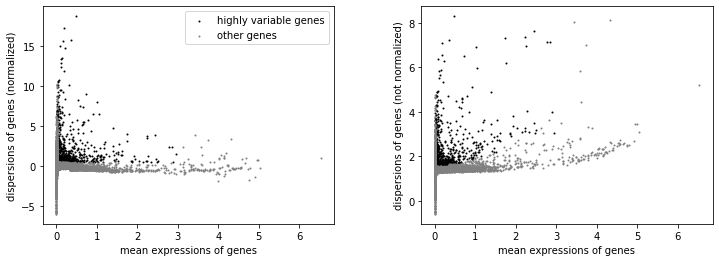

In [25]:
# equivalent to the DESeq2 MA-plot
sc.pl.highly_variable_genes(scLN)

In [26]:
scLN.raw = scLN

In [27]:
# proceed only with the highly variable genes
scLN = scLN[:, scLN.var.highly_variable]
# now we proceed with only 916 instead of 29634 genes

In [28]:
# scale data to unit variance
sc.pp.scale(scLN, max_value=10)

/Users/albero/scanpy/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


### 3. Low dimensional (UMAP) embedding and Clustering

In [29]:
sc.tl.pca(scLN, svd_solver='arpack')

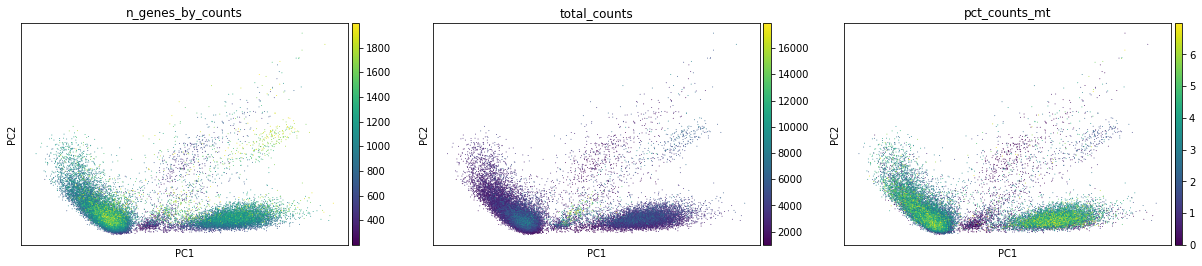

In [30]:
sc.pl.pca(scLN, color=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'])

Now, let's have a quick look at the annotations of the cells provided by Kim et al. 

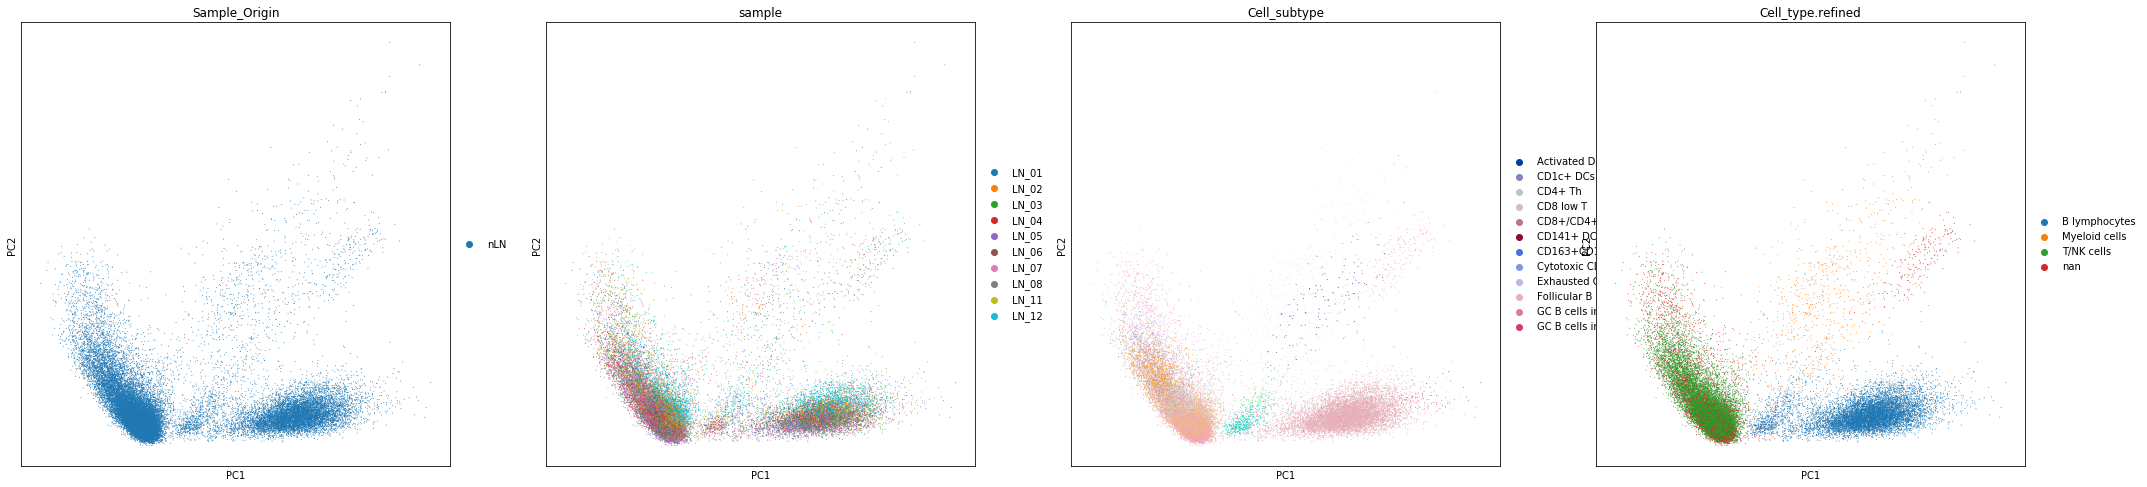

In [31]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.pca(scLN, color=['Sample_Origin', 'sample', 'Cell_subtype', 'Cell_type.refined'])

As expected all samples are from normal Lymph Nodes. The different clusters are equally composed of cells from the different donors. This speaks against a big batch effect. The cell_types nicely form clusters and the cell_subclusters are located within the clusters of the respective cell_types. However, it is remarkable, that the myeloid cells and the T/NK cells co-cluster. Let's have a look at this later!

In [32]:
# compute the neighbors
sc.pp.neighbors(scLN)

In [33]:
# compute UMAP and Leiden clustering with the granularity 1. 
sc.tl.umap(scLN)
sc.tl.leiden(scLN, key_added="leiden_1")
sc.tl.leiden(scLN, key_added="leiden_05", resolution=0.5)
sc.tl.leiden(scLN, key_added="leiden_025", resolution=0.25)

Let's compare the clustering results provided by Kim et al. and the ones I got with Leiden.

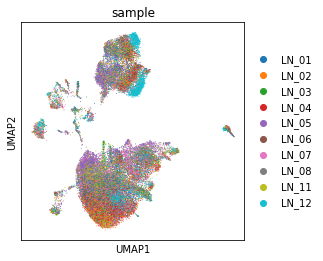

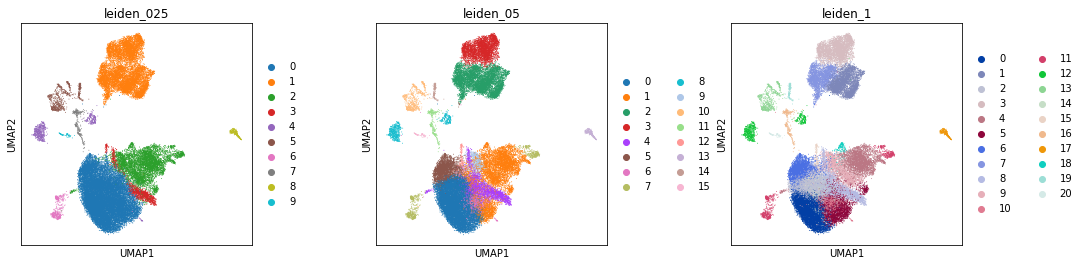

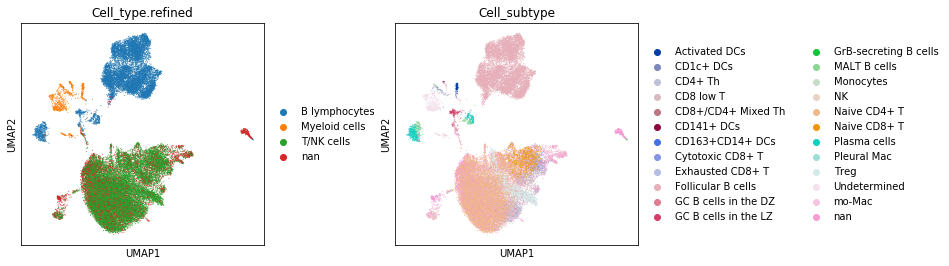

In [34]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(scLN, color=["sample"], wspace=0.4)
sc.pl.umap(scLN, color=["leiden_025", "leiden_05", "leiden_1"], wspace=0.4)
sc.pl.umap(scLN, color=['Cell_type.refined', "Cell_subtype"], wspace=0.4)
# sc.pl.umap(scLN, color=["sample", "leiden_1", "leiden_05", 'Cell_type.refined', "Cell_subtype"], wspace=0.4)

In [35]:
marker_genes_dict = {'NK': ['GNLY', 'NKG7'],
                     'T-cell': ['CD3D', 'PTPRC', 'CD4', 'CD8A'],
                     'B-cell': ['CD79A', 'MS4A1', 'MS4A1'],
                     'Monocytes': ['FCGR3A', 'CD14', 'CD68'],
                     'Dendritic': ['FCER1A', "CD1C", 'THBD']}

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


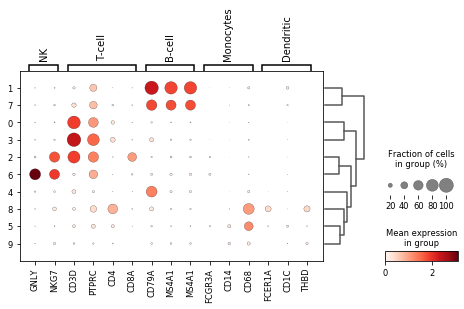

In [36]:
sc.pl.dotplot(scLN, marker_genes_dict, 'leiden_025', dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


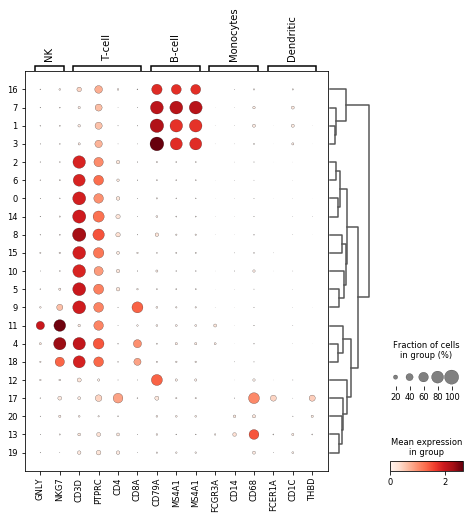

In [37]:
sc.pl.dotplot(scLN, marker_genes_dict, 'leiden_1', dendrogram=True)

categories: Activated DCs, CD1c+ DCs, CD4+ Th, etc.
var_group_labels: NK, T-cell, B-cell, etc.


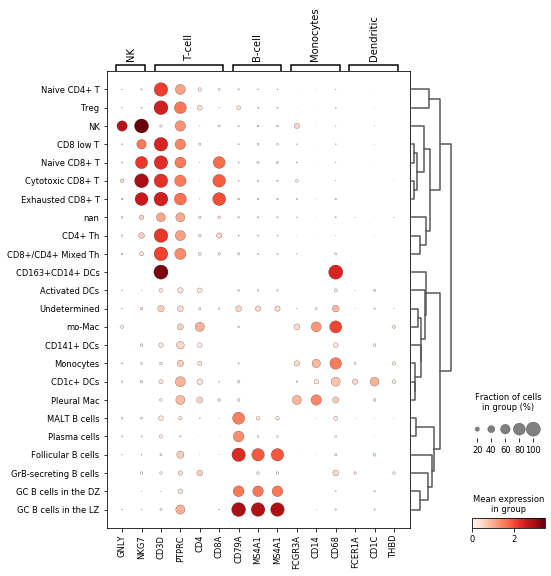

In [38]:
sc.pl.dotplot(scLN, marker_genes_dict, "Cell_subtype", dendrogram=True)

It is very visible, that the clusters and cluster annotations provided by Kim et al. are much better at identifying cells with known marker genes than my Leiden clustering at different resolutions. Especially the Myeloid subsets (Monocytes, DCs) are badly captured.

Clustering with higher resolution seem to be better at capturing known marker genes. It might be the case, that those markers are diluted out in larger clusters.  
Let's try Leiden clustering with a higer resolulution. Do we capture the marker genes now?

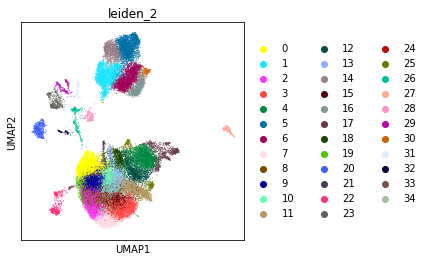

In [39]:
sc.tl.leiden(scLN, key_added="leiden_2", resolution=2)
sc.pl.umap(scLN, color=["leiden_2"], wspace=0.4)

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


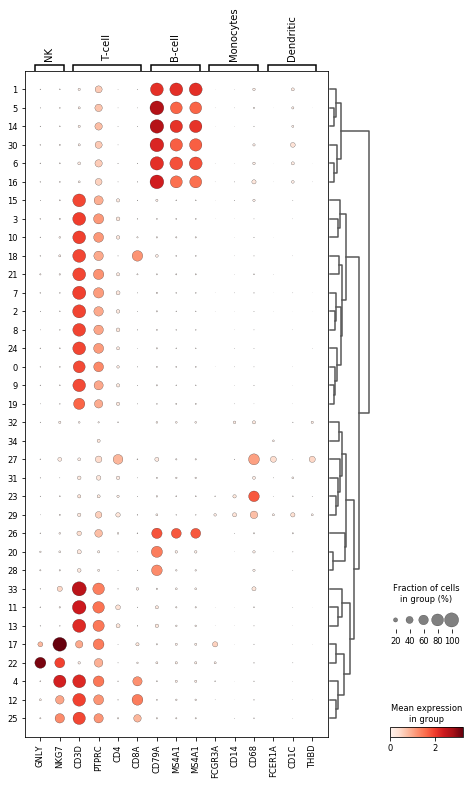

In [40]:
sc.pl.dotplot(scLN, marker_genes_dict, "leiden_2", dendrogram=True)

Still, the myeloid cells are not really represented. Why? It seems as if there are very specific transcriptional marker genes for cell types that not necessarily the ones we commonly use for FACS staining!

### 4. Perform trajectory analysis (define traj_state_bins)

Trajectory analysis based on the recommendations in https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170502_paul15/paul15.ipynb

First select only on the B cells 

In [49]:
scLN_bc = scLN[scLN.obs["Cell_type.refined"] == "B lymphocytes"]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


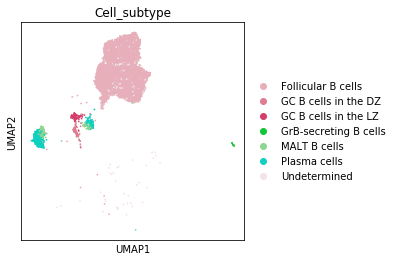

In [124]:
sc.pl.umap(scLN_bc, color=["Cell_subtype"], wspace=0.4)

Run PCA now only on the BCs

In [ ]:
sc.tl.pca(scLN_bc, svd_solver='arpack')

Compute Neighborhood graph on the the PCA results.

In [72]:
sc.pp.neighbors(scLN_bc, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(scLN_bc)

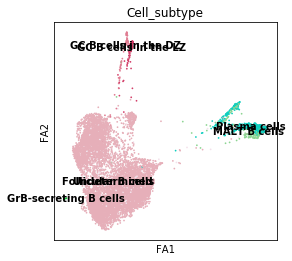

In [75]:
sc.pl.draw_graph(scLN_bc, color='Cell_subtype', legend_loc='on data')

Compute PAGA on the data 

In [76]:
sc.tl.paga(scLN_bc, groups='Cell_subtype')

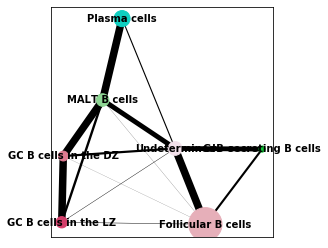

In [87]:
sc.pl.paga(scLN_bc, color=['Cell_subtype'])

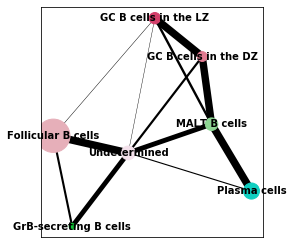

In [90]:
sc.pl.paga(scLN_bc, threshold=0.03, show=False)

Calculate and Plot PAGA-based single-cell embedding.

In [91]:
sc.tl.draw_graph(scLN_bc, init_pos='paga')

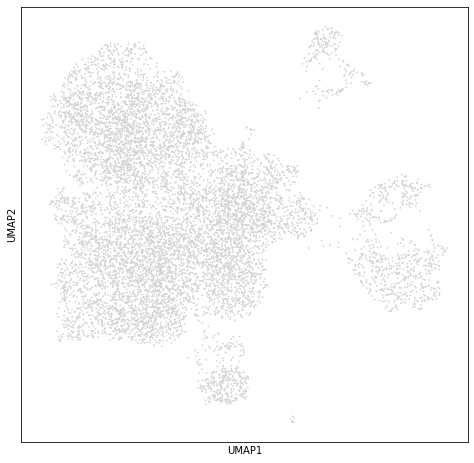

In [185]:
sc.tl.umap(scLN_bc, init_pos='paga')
sc.pl.umap(scLN_bc)

In [186]:
sc.tl.diffmap(scLN_bc)

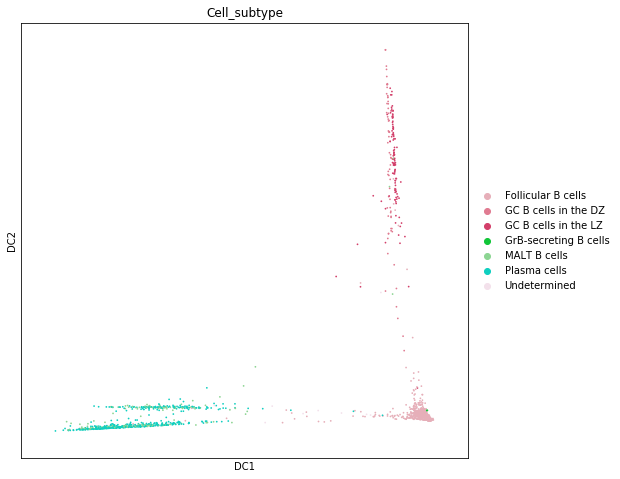

In [187]:
sc.pl.diffmap(scLN_bc, color=['Cell_subtype'])

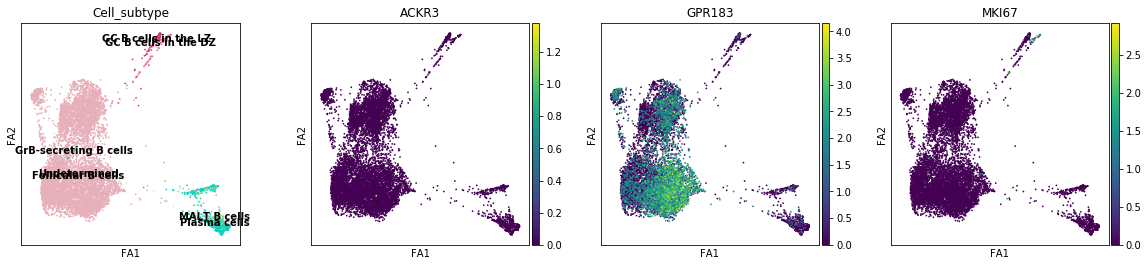

In [109]:
sc.pl.draw_graph(scLN_bc, color=['Cell_subtype', "ACKR3", "GPR183", "MKI67"], legend_loc='on data')

In [108]:
scLN_bc

AnnData object with n_obs × n_vars = 9826 × 916
    obs: 'sample', 'Sample_Origin', 'Cell_type.refined', 'Cell_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_1', 'leiden_05', 'leiden_025', 'leiden_2', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'Sample_Origin_colors', 'sample_colors', 'Cell_subtype_colors', 'Cell_type.refined_colors', 'neighbors', 'umap', 'leiden', 'leiden_025_colors', 'leiden_05_colors', 'leiden_1_colors', 'dendrogram_leiden_025', 'dendrogram_leiden_1', 'dendrogram_Cell_subtype', 'leiden_2

In [115]:
sc.tl.diffmap(scLN_bc)

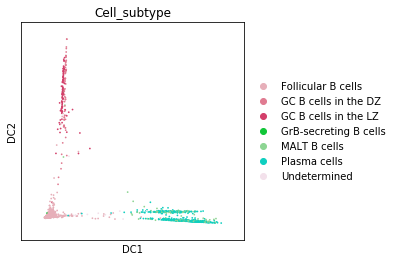

In [117]:
sc.pl.diffmap(scLN_bc, color='Cell_subtype')

Let's have a look at T cells

In [122]:
scLN_tc = scLN[scLN.obs["Cell_type.refined"] == "T/NK cells"]

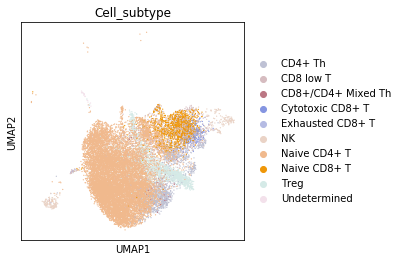

In [125]:
sc.pl.umap(scLN_tc, color=["Cell_subtype"], wspace=0.4)

In [126]:
sc.tl.pca(scLN_tc, svd_solver='arpack')

In [129]:
sc.pp.neighbors(scLN_tc, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(scLN_tc)

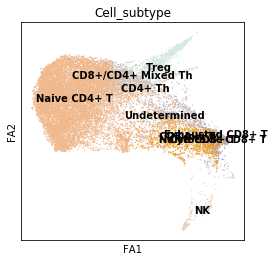

In [130]:
sc.pl.draw_graph(scLN_tc, color='Cell_subtype', legend_loc='on data')

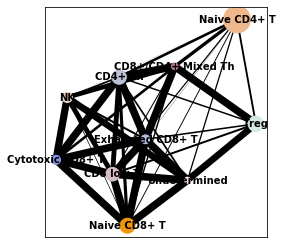

In [131]:
sc.tl.paga(scLN_tc, groups='Cell_subtype')
sc.pl.paga(scLN_tc, color=['Cell_subtype'])

In [132]:
# embedding of single cells on PAGA
sc.tl.draw_graph(scLN_tc, init_pos='paga')

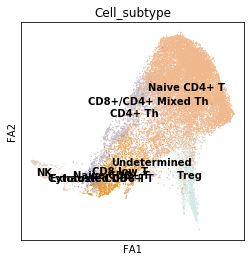

In [133]:
sc.pl.draw_graph(scLN_tc, color=['Cell_subtype'], legend_loc='on data')

### 5. run ligrec with CellPhoneDB to predict CCI

In [138]:
res_scLN = sq.gr.ligrec(scLN, "Cell_subtype",
                   fdr_method=None, copy=True,
                   interactions_params={"resources": "CellPhoneDB"},
                   threshold=0.1, seed=0, n_jobs=1) #  n_perms=10000 removed --> default is 10000
df_res_scLN = res_scLN.pvalues

/opt/anaconda3/lib/python3.7/site-packages/omnipath/_core/requests/_utils.py:155: FutureWarning: The default value of regex will change from True to False in a future version.
  _split_unique_join(data.str.replace(r"[-\w]*:?(\d+)", r"\1")), func=func


  0%|          | 0/1000 [00:00<?, ?permutation/s]

In [139]:
print("Number of CellPhoneDB interactions:", len(df_res_scLN))

df_res_scLN.head()

Number of CellPhoneDB interactions: 444


cluster_1     Activated DCs                                               \
cluster_2     Activated DCs CD141+ DCs CD163+CD14+ DCs CD1c+ DCs CD4+ Th   
source target                                                              
JAG2   NOTCH1           NaN        NaN             NaN       NaN     NaN   
DLL1   NOTCH1           NaN        NaN             NaN       NaN     NaN   
JAG1   NOTCH1           NaN        NaN             NaN       NaN     NaN   
TNF    NOTCH1           NaN        NaN             NaN       NaN     NaN   
DLL4   NOTCH1           NaN        NaN             NaN       NaN     NaN   

cluster_1                                                                     \
cluster_2     CD8 low T CD8+/CD4+ Mixed Th Cytotoxic CD8+ T Exhausted CD8+ T   
source target                                                                  
JAG2   NOTCH1       NaN                NaN              NaN              NaN   
DLL1   NOTCH1       NaN                NaN              NaN              NaN   
JAG1   NOTCH1       NaN                NaN              NaN              NaN   
TNF    NOTCH1       NaN                NaN              NaN              NaN   
DLL4   NOTCH1       NaN                NaN              NaN              NaN   

cluster_1                         ...       nan                                \
cluster_2     Follicular B cells  ... Monocytes  NK Naive CD4+ T Naive CD8+ T   
source target                     ...                                           
JAG2   NOTCH1                NaN  ...       NaN NaN          NaN          NaN   
DLL1   NOTCH1                NaN  ...       NaN NaN          NaN          NaN   
JAG1   NOTCH1                NaN  ...       NaN NaN          NaN          NaN   
TNF    NOTCH1                NaN  ...       NaN NaN          NaN          NaN   
DLL4   NOTCH1                NaN  ...       NaN NaN          NaN          NaN   

cluster_1                                                            
cluster_2     Plasma cells Pleural Mac Treg Undetermined mo-Mac nan  
source target                                                        
JAG2   NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  
DLL1   NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  
JAG1   NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  
TNF    NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  
DLL4   NOTCH1          NaN         NaN  NaN          NaN    NaN NaN  

[5 rows x 576 columns]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


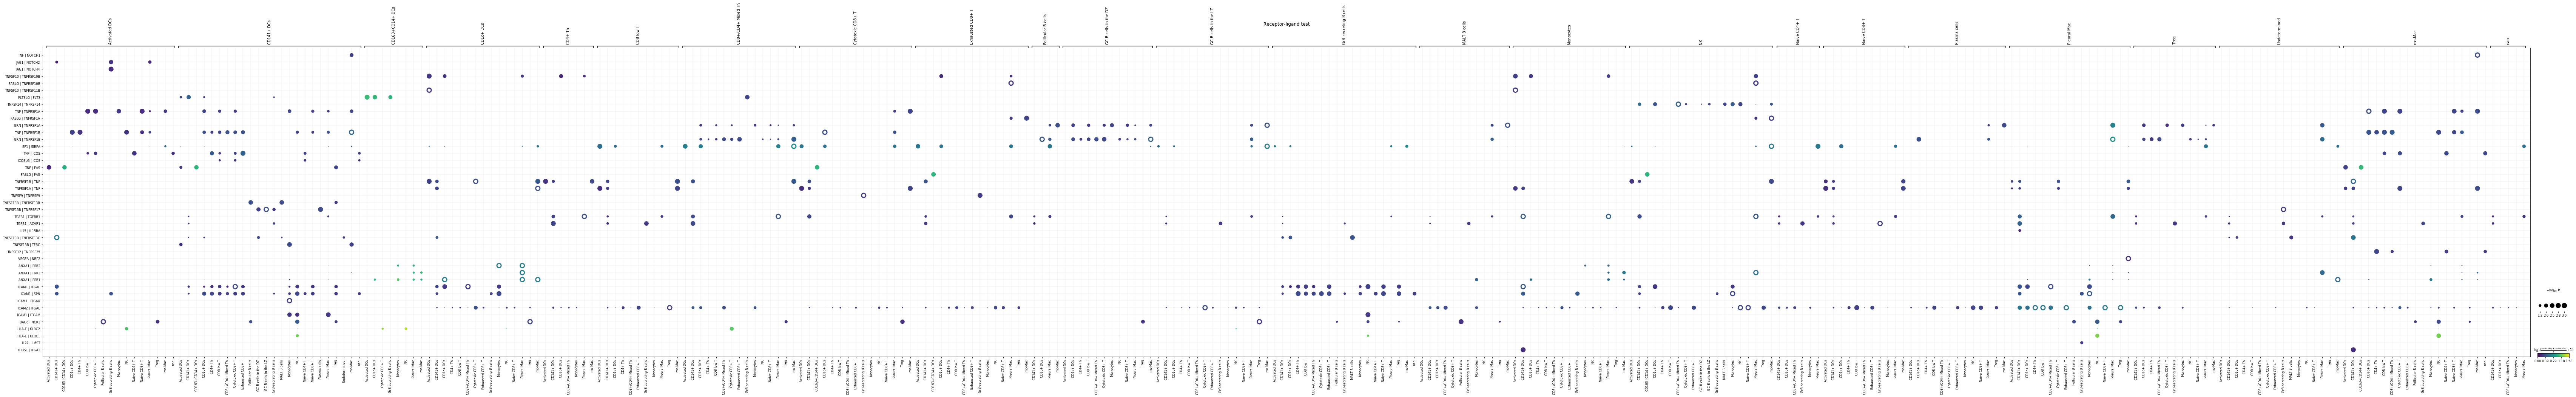

In [142]:
sq.pl.ligrec(res_scLN)

## II. Visium data 

Basic processing pipeline take from: https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html

### 1. Load data

In [158]:
# Load prestored Lymph Node Visium data set
visiumLN = sc.datasets.visium_sge('V1_Human_Lymph_Node')
visiumLN.var_names_make_unique()
visiumLN.var["mt"] = visiumLN.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(visiumLN, qc_vars=["mt"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


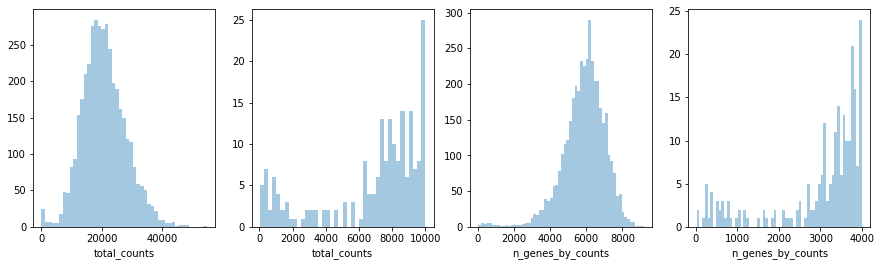

In [159]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(visiumLN.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(visiumLN.obs["total_counts"][visiumLN.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(visiumLN.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(visiumLN.obs["n_genes_by_counts"][visiumLN.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [160]:
sc.pp.filter_cells(visiumLN, min_counts=5000)
sc.pp.filter_cells(visiumLN, max_counts=35000)
visiumLN = visiumLN[visiumLN.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {visiumLN.n_obs}")
sc.pp.filter_genes(visiumLN, min_cells=10)

#cells after MT filter: 3861


Trying to set attribute `.var` of view, copying.


In [161]:
sc.pp.normalize_total(visiumLN, inplace=True)
sc.pp.log1p(visiumLN)
sc.pp.highly_variable_genes(visiumLN, flavor="seurat", n_top_genes=2000)

### 2. Identify clusters

In [162]:
sc.pp.pca(visiumLN)
sc.pp.neighbors(visiumLN)
sc.tl.umap(visiumLN)
sc.tl.leiden(visiumLN, key_added="leiden_1")

In [163]:
sc.tl.leiden(visiumLN, key_added="leiden_05", resolution=0.5)
sc.tl.leiden(visiumLN, key_added="leiden_025", resolution=0.25)

sc.tl.leiden(visiumLN, key_added="leiden_2", resolution=2)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


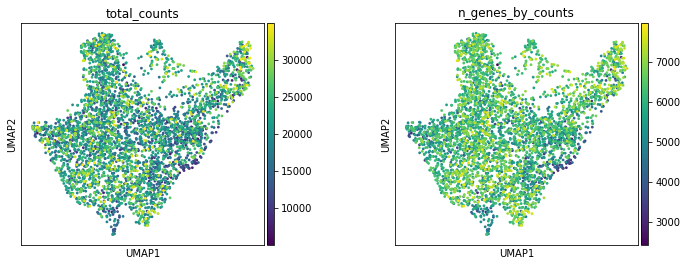

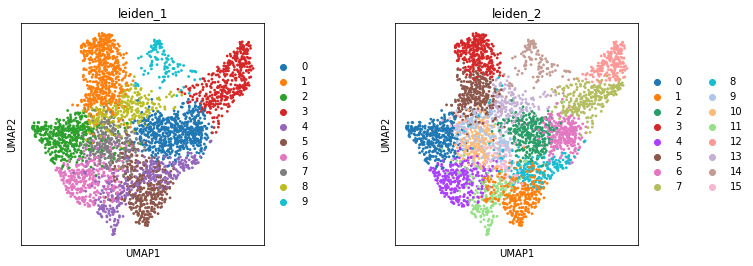

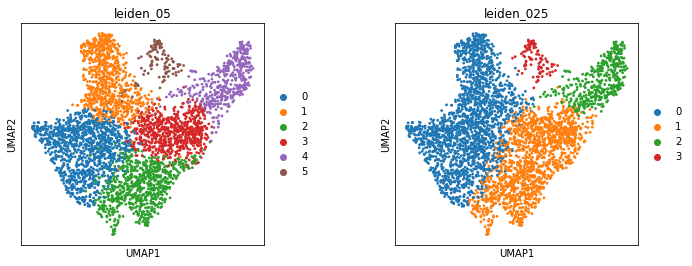

In [164]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(visiumLN, color=["total_counts", "n_genes_by_counts"], wspace=0.4)
sc.pl.umap(visiumLN, color=["leiden_1", "leiden_2"], wspace=0.4)
sc.pl.umap(visiumLN, color=["leiden_05", "leiden_025"], wspace=0.4)

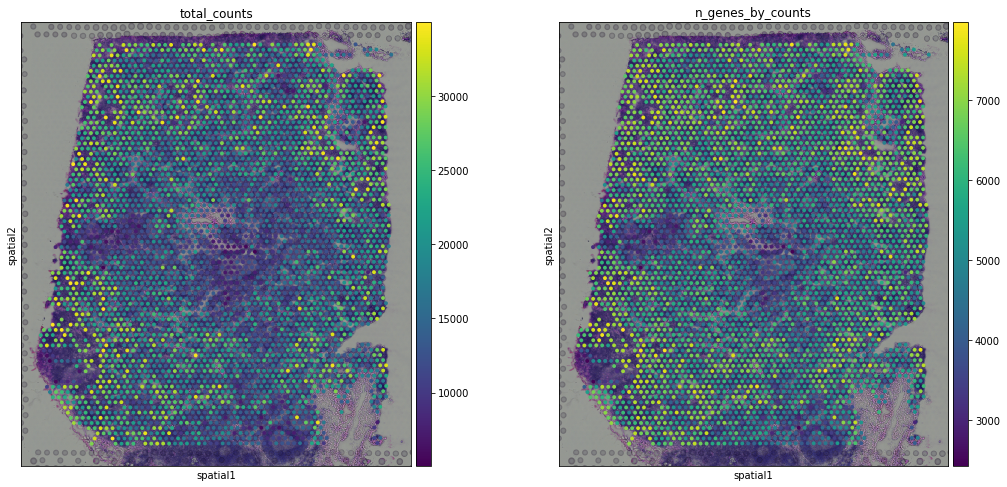

In [165]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(visiumLN, img_key="hires", color=["total_counts", "n_genes_by_counts"])

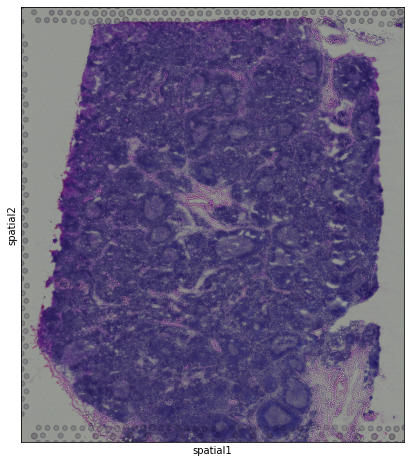

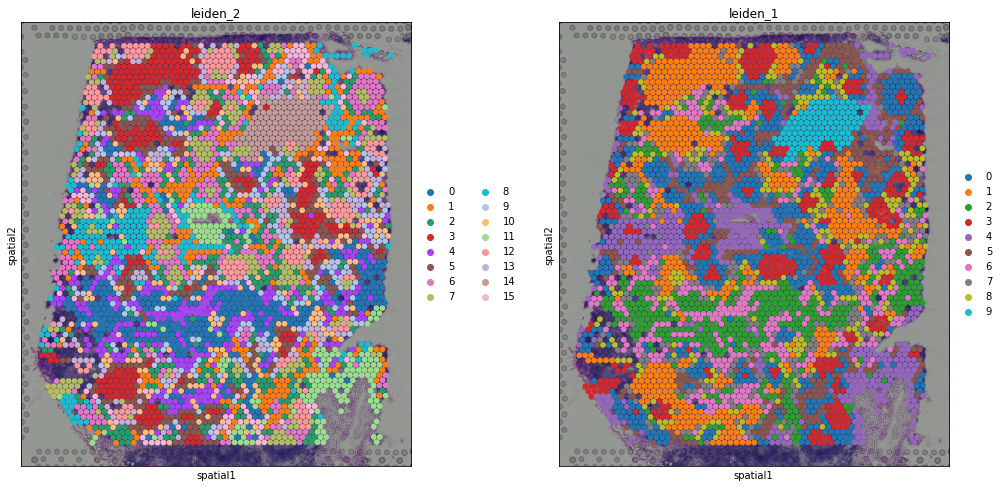

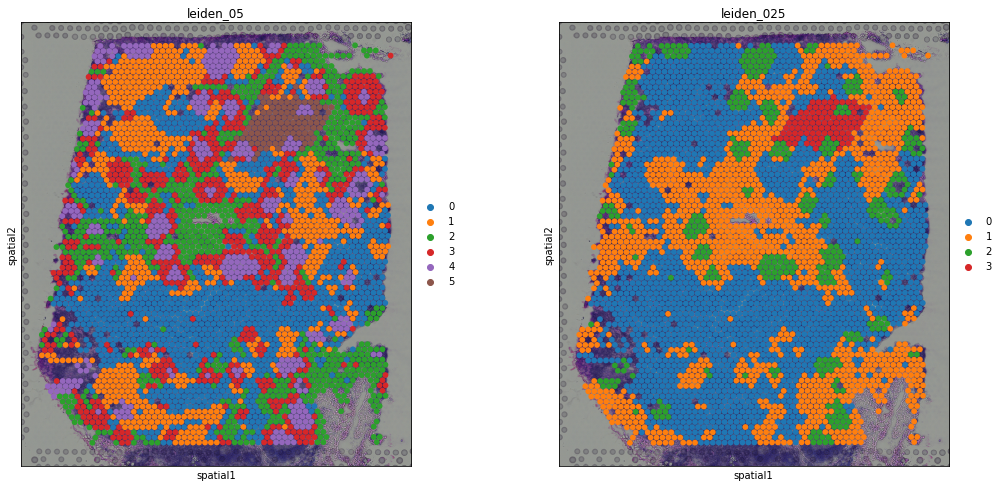

In [166]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(visiumLN, img_key="hires", color= None, size=1.5)
sc.pl.spatial(visiumLN, img_key="hires", color=["leiden_2", "leiden_1"], size=1.5)
sc.pl.spatial(visiumLN, img_key="hires", color=["leiden_05", "leiden_025"], size=1.5)

Leiden 1 seems to be the best resolution.

### 3. Deconvolute clusters with cell types/traj_state_bins

### 4. Run LigRec on clusters

In [168]:
visiumLN.raw = visiumLN

In [169]:
res_visium = sq.gr.ligrec(visiumLN, "leiden_1",
                   fdr_method=None, copy=True,
                   interactions_params={"resources": "CellPhoneDB"},
                   threshold=0.1, seed=0, n_jobs=1) #  n_perms=10000 removed --> default is 10000
df_res_visium = res_visium.pvalues

/opt/anaconda3/lib/python3.7/site-packages/omnipath/_core/requests/_utils.py:155: FutureWarning: The default value of regex will change from True to False in a future version.
  _split_unique_join(data.str.replace(r"[-\w]*:?(\d+)", r"\1")), func=func


  0%|          | 0/1000 [00:00<?, ?permutation/s]

In [170]:
print("Number of CellPhoneDB interactions:", len(df_res_visium))

df_res_visium.head()

Number of CellPhoneDB interactions: 316


cluster_1          0                                                          \
cluster_2          0      1      2      3      4      5      6      7      8   
source target                                                                  
JAG2   NOTCH1  0.230  0.368  1.000  1.000  1.000  0.318  0.696  0.507  0.667   
DLL1   NOTCH1  0.660  0.820  1.000  1.000  1.000  0.687  0.921  0.801  0.881   
JAG1   NOTCH1  0.927  0.976  1.000  1.000  1.000  0.914  0.992  0.950  0.982   
TNF    NOTCH1    NaN    NaN  0.490  0.927  0.969    NaN  0.010  0.005  0.012   
DLL4   NOTCH1  0.170  0.307  0.995  1.000  1.000  0.257  0.622  0.410  0.570   

cluster_1             ...      9                                            \
cluster_2          9  ...      0      1      2      3      4      5      6   
source target         ...                                                    
JAG2   NOTCH1  0.387  ...  0.086  0.165  0.954  0.998  1.000  0.152  0.376   
DLL1   NOTCH1  0.624  ...  0.239  0.331  0.967  0.996  0.997  0.306  0.543   
JAG1   NOTCH1  0.810  ...  0.346  0.459  0.979  0.998  0.998  0.402  0.642   
TNF    NOTCH1  0.029  ...  0.018  0.036  0.817  0.977  0.991  0.049  0.182   
DLL4   NOTCH1  0.348  ...  0.107  0.168  0.852  0.978  0.987  0.153  0.349   

cluster_1                           
cluster_2          7      8      9  
source target                       
JAG2   NOTCH1  0.242  0.381  0.241  
DLL1   NOTCH1  0.397  0.502  0.331  
JAG1   NOTCH1  0.509  0.622  0.413  
TNF    NOTCH1  0.100  0.177  0.112  
DLL4   NOTCH1  0.231  0.332  0.211  

[5 rows x 100 columns]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


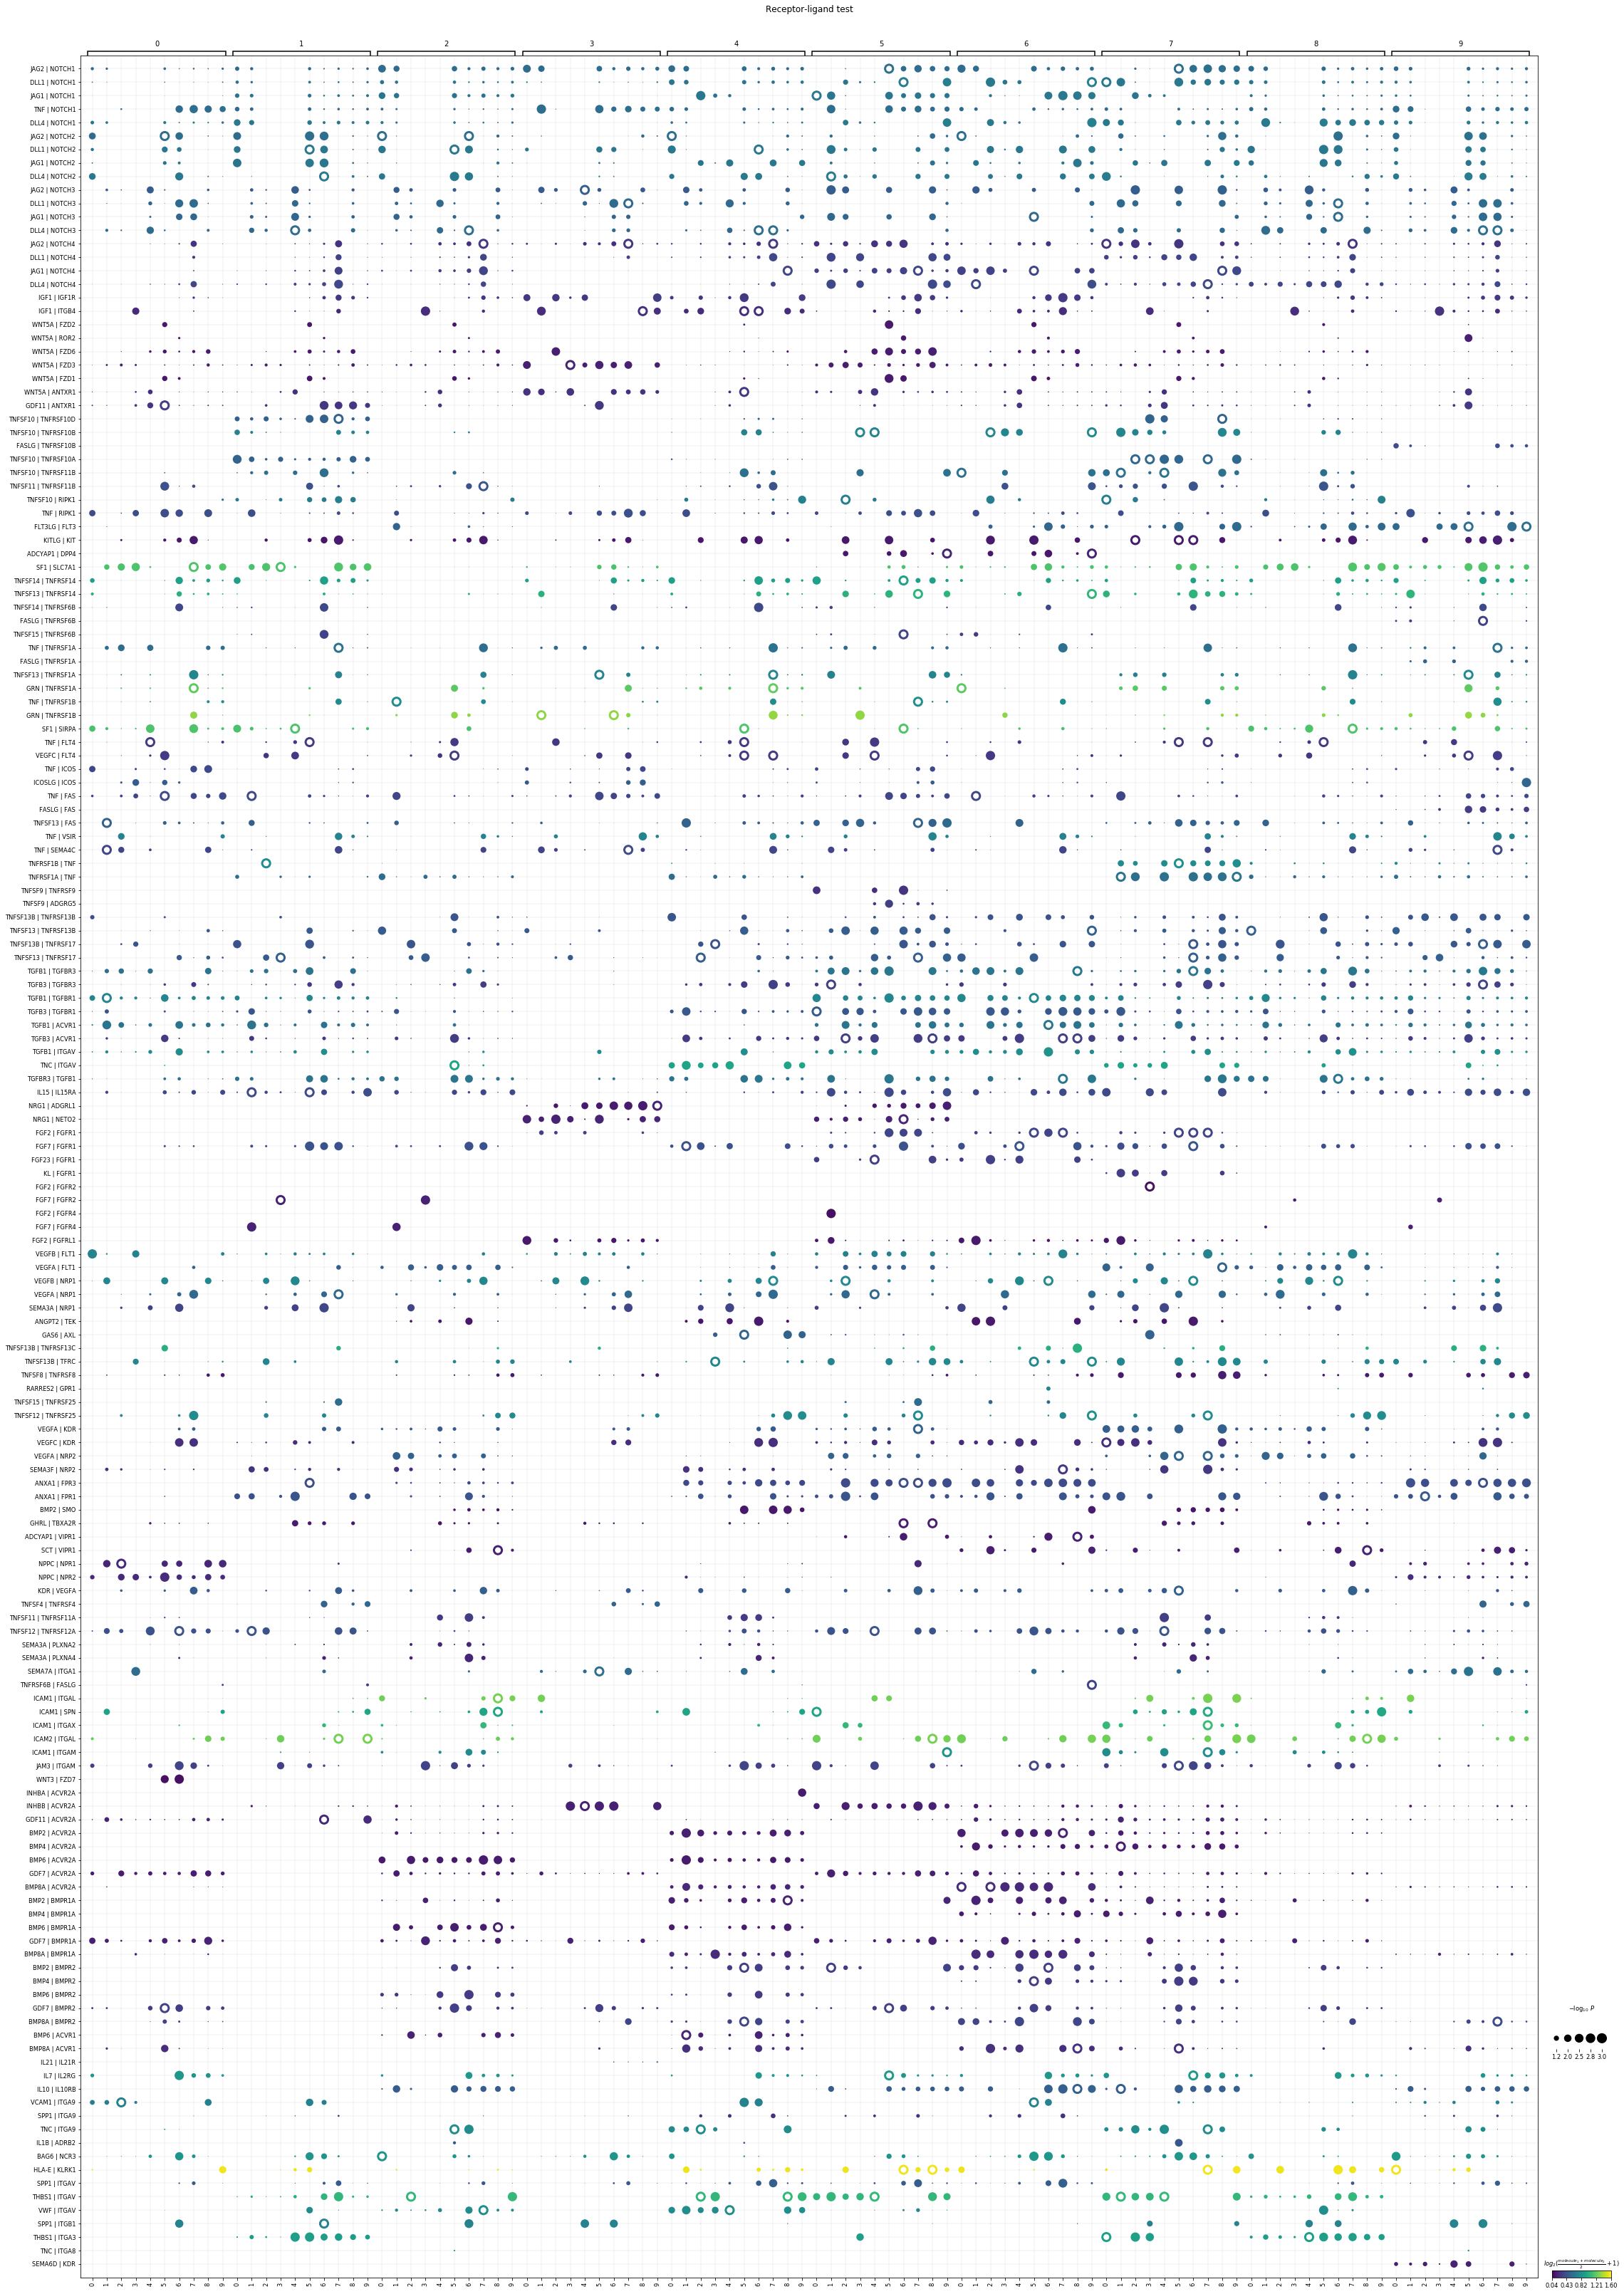

In [171]:
sq.pl.ligrec(res_visium)

In [179]:
sq.gr.spatial_neighbors(visiumLN)
sq.gr.nhood_enrichment(visiumLN, cluster_key="leiden_1")

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.X` of view, copying.


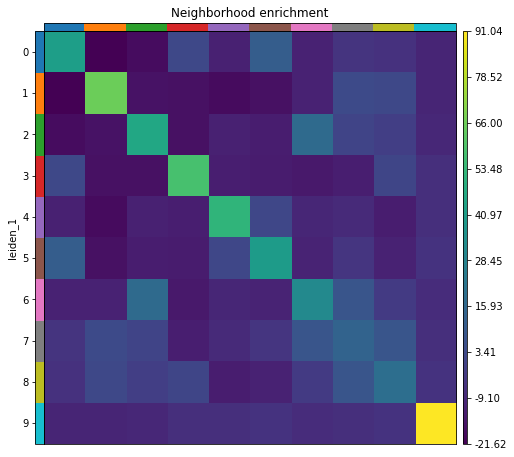

In [180]:
sq.pl.nhood_enrichment(visiumLN, cluster_key="leiden_1")

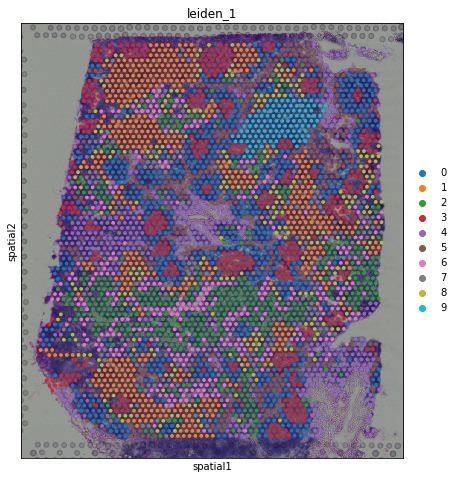

In [181]:
sc.pl.spatial(visiumLN, color = "leiden_1")